### **Introdução e contextualização**

A empresa Clamed Data Insights, especializada em soluções de análise de dados voltadas para o setor de saúde, recebeu uma base de informações de um conjunto de clínicas e hospitais. O objetivo é identificar padrões, anomalias e tendências que possam apoiar decisões estratégicas sobre qualidade de atendimento, custos e eficiência operacional.


### **Leitura do dataset e importação das bibliotecas que serão utilizadas**

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando matplotlib para notebooks
%matplotlib inline

# Leitura do dataset
df_dataset = pd.read_csv('healthcare_dataset.csv')

### **Limpeza e preparação dos dados**

In [ ]:
# Leitura inicial dos dados
# - df_dataset.head()
# - df_dataset.info()
# - df_dataset.describe().round(2)
# - df_dataset.shape
# - (df_dataset.duplicated().sum())

# Problemas identificados na análise inicial:
# - Duplicatas encontradas
# - Valores ausentes em algumas colunas
# - Data de admissão como object em vez de datetime
# - Valores negativos em colunas que deveriam ser positivas

# Iniciando a limpeza dos dados:
# Identificando e removendo duplicatas
(df_dataset.duplicated(subset=['Name', 'Date of Admission', 'Test Results']).sum()) # Verificando as duplicatas pelo nome, data de admissão e resultados de testes
df_dataset = df_dataset.drop_duplicates(
    subset=['Name', 'Date of Admission', 'Test Results'],
    keep='first'
)

# Convertendo datas para o formato datetime
df_dataset['Date of Admission'] = pd.to_datetime(df_dataset['Date of Admission'], errors='coerce')
df_dataset['Discharge Date'] = pd.to_datetime(df_dataset['Discharge Date'], errors='coerce')

# Padronizando a coluna 'Name'
df_dataset['Name'] = df_dataset['Name'].str.title().str.strip()

# Padronizando nomes dos hospitais (removendo sufixos comuns e variações)
def standardize_hospital_name(name):
    if pd.isna(name):
        return name
    
    # Converter para string e limpar
    name = str(name).strip()
    
    # Remover sufixos comuns (LLC, Inc, Ltd, Group, PLC, etc.)
    suffixes = [' LLC', ' Inc', ' Ltd', ' Group', ' PLC', ' Corp', ' Corporation']
    for suffix in suffixes:
        name = name.replace(suffix, '')
    
    # Remover prefixos de sufixos (Group X → X, Ltd X → X)
    prefixes = ['Group ', 'Ltd ', 'Inc ', 'LLC ']
    for prefix in prefixes:
        if name.startswith(prefix):
            name = name.replace(prefix, '', 1)
    
    # Limpar espaços extras e padronizar capitalização
    name = ' '.join(name.split()).title()
    
    return name

df_dataset['Hospital'] = df_dataset['Hospital'].apply(standardize_hospital_name)

# Identificando e removendo outliers via IQR em colunas numéricas
numeric_cols = ['Age', 'Billing Amount', 'Room Number']
for col in numeric_cols:
    Q1 = df_dataset[col].quantile(0.25)
    Q3 = df_dataset[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_dataset = df_dataset[(df_dataset[col] >= lower_bound) & (df_dataset[col] <= upper_bound)]

### **Enriquecimento e Feature Engineering**

In [ ]:
# Criando uma tabela para classificação de idades (jovem, adulto, idoso)
def classify_age(age):
    if age < 18:
        return 'Young'
    elif 18 <= age < 60:
        return 'Adult'
    else:
        return 'Senior'

df_dataset['Age Group'] = df_dataset['Age'].apply(classify_age)

# Criando tabela de dias de internação
df_dataset['Days Admitted'] = (df_dataset['Discharge Date'] - df_dataset['Date of Admission']).dt.days
df_dataset['Days Admitted'] = df_dataset['Days Admitted'].fillna(0).astype(int)

# Criando coluna para filtrar pacientes ainda internados e pacientes com alta
df_dataset['Still Admitted'] = df_dataset['Discharge Date'].isna()


# Calculando o custo diário por paciente
df_dataset['Cost_Per_Day'] = df_dataset.apply(
    lambda row: row['Billing Amount'] / row['Days Admitted'] if row['Days Admitted'] > 0 else row['Billing Amount'],
    axis=1
)

### **Análise Exploratória**

In [ ]:
# Calculando o custo médio por grupo etário
avg_cost_by_age_group = df_dataset.groupby('Age Group')['Cost_Per_Day'].mean().sort_values(ascending=False).round(2)

# Diferença entre homens e mulheres em termos de custo médio diário
avg_cost_by_gender = df_dataset.groupby('Gender')['Cost_Per_Day'].mean().sort_values(ascending=False).round(2)

# Calculando qual hospital tem maior volume de pacientes
patients_by_hospital = df_dataset['Hospital'].value_counts().sort_values(ascending=False)

### **Insights/Visualizações - Qual o custo médio diário por grupo etário?**

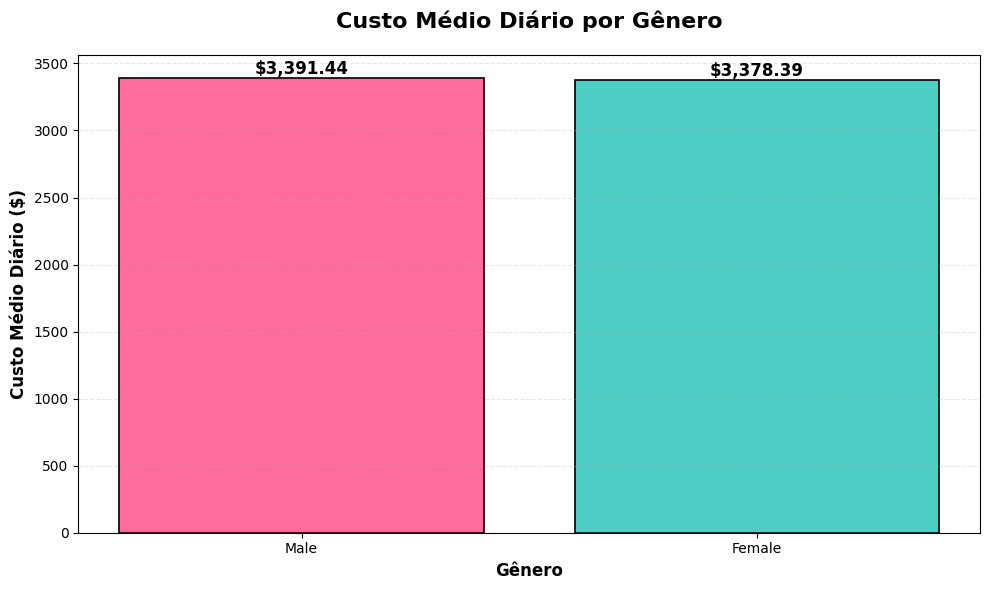

In [52]:
# Visualizando o custo médio por gênero
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_cost_by_gender.index, 
               avg_cost_by_gender.values,
               color=['#FF6B9D', '#4ECDC4'],
               edgecolor='black',
               linewidth=1.2)

# Adicionando os valores no topo de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Custo Médio Diário por Gênero', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Gênero', fontsize=12, fontweight='bold')
plt.ylabel('Custo Médio Diário ($)', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### **Insights/Visualizações - Qual o custo médio diário por grupo etário?**

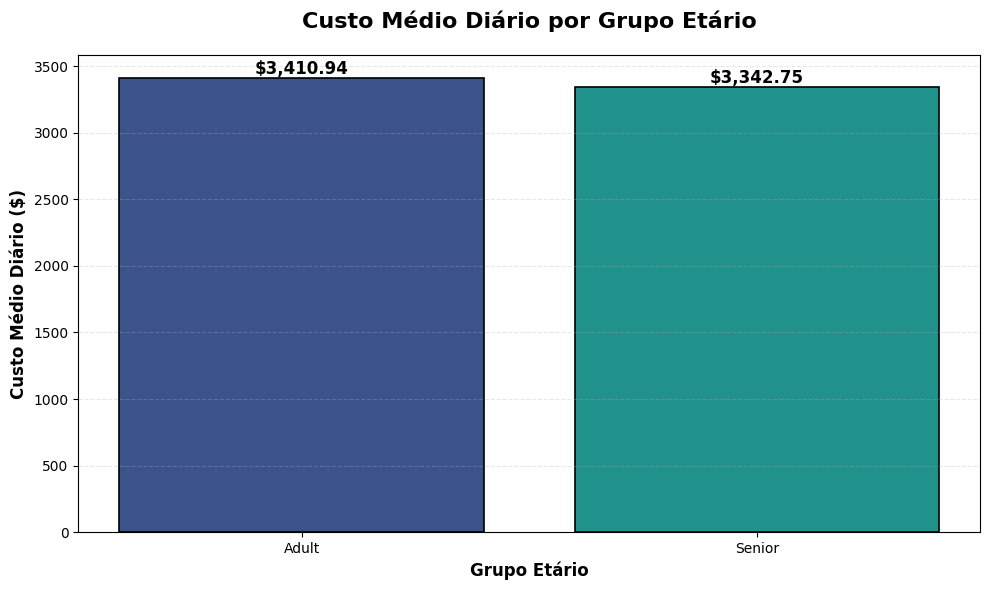

In [53]:
# Visualizando o custo médio por grupo etário
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_cost_by_age_group.index, 
               avg_cost_by_age_group.values,
               color=sns.color_palette('viridis', 3),
               edgecolor='black',
               linewidth=1.2)

# Adicionando os valores no topo de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${height:,.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Custo Médio Diário por Grupo Etário', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Grupo Etário', fontsize=12, fontweight='bold')
plt.ylabel('Custo Médio Diário ($)', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### **Insights/Visualizações - Quais hospitais tem o maior volume de pacientes?**

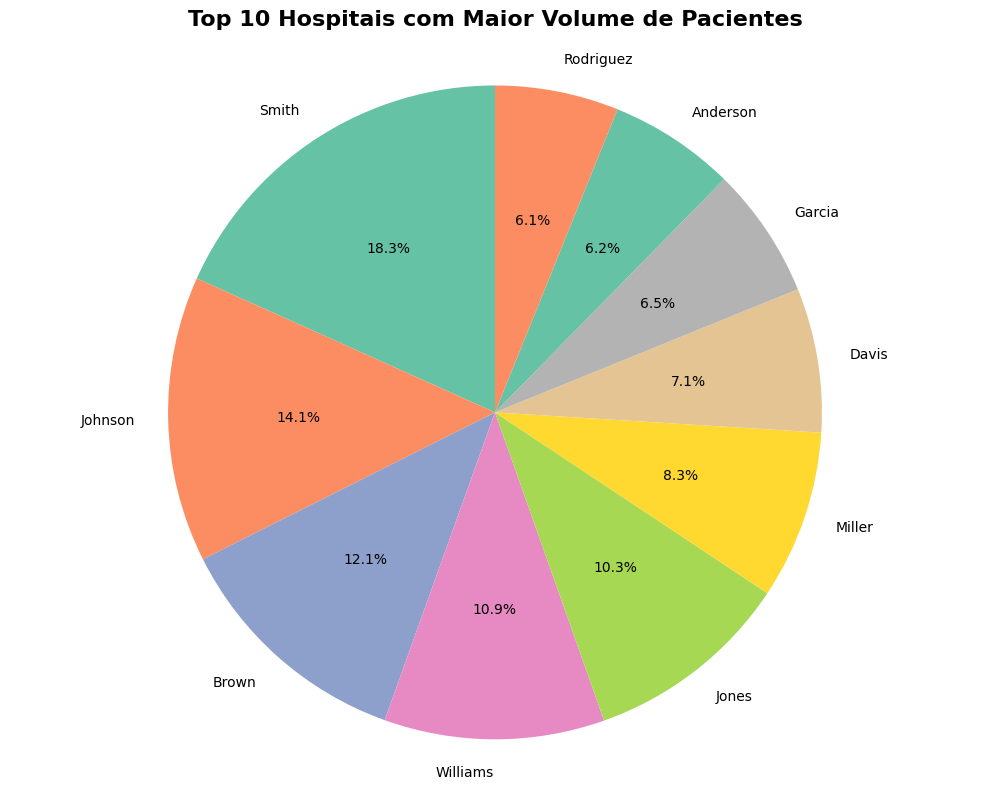

In [54]:
# Selecionando apenas o top 10
top_10_hospitals = patients_by_hospital.head(10)

# Visualizando o top 10 hospitais com maior volume de pacientes
plt.figure(figsize=(10, 8))
plt.pie(top_10_hospitals.values, 
        labels=top_10_hospitals.index, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=sns.color_palette('Set2', 10))
plt.title('Top 10 Hospitais com Maior Volume de Pacientes', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

## **Relatório Final de Análise**

---

### **Principais Padrões Identificados**

1. **Distribuição de Custos por Grupo Etário**
   - Os custos médios diários são semelhantes levando em consideração os grupos etários

2. **Diferenças de Custo entre Gêneros**
   - Observa-se também uma semelhança nos custos médios diários entre os gêneros (Female e Male)

3. **Concentração de Pacientes em Hospitais**
   - Os 3 principais hospitais (Smith, Johnson e Brown) concentram uma parcela significativa do volume total de pacientes
   - Esta concentração pode sugerir maior qualidade de atendimento ou ainda fatores como localização estratégica, maior capacidade operacional ou maior número de convênios aceitos

4. **Qualidade dos Dados**
   - Foram identificadas e removidas duplicatas no dataset
   - Outliers foram tratados utilizando o método IQR
   - Padronizações foram aplicadas para garantir consistência nas análises

---

### **Comportamentos Inesperados nos Dados**

1. **Presença de Duplicatas**
   - Foram encontradas entradas duplicadas baseadas em nome do paciente, data de admissão, resultados de testes e nomes de hospitais
   - Possível causa: falhas no sistema de registro ou múltiplas entradas para o mesmo evento clínico

2. **Outliers em Variáveis Numéricas**
   - Valores extremos foram identificados em colunas como idade, valor de cobrança e número do quarto
   - Estes outliers podem representar casos excepcionais legítimos ou erros de digitação/sistema

3. **Valores Ausentes**
   - Algumas colunas apresentaram valores ausentes, particularmente em datas de alta
   - Isto pode indicar pacientes ainda internados ou falhas no registro de alta

4. **Variação nos Custos Diários**
   - A amplitude de custos por dia entre diferentes pacientes foi considerável
   - Sugere grande heterogeneidade nos tipos de tratamento, condições médicas e recursos utilizados

---

### **Hipóteses para Futuras Análises**

1. **Relação entre Condição Médica e Custos**
   - **Hipótese:** Condições médicas específicas (ex: câncer, doenças cardíacas) apresentam custos significativamente maiores que outras
   - **Análise sugerida:** Comparar custos médios por categoria de doença e identificar condições que demandam mais recursos

2. **Impacto do Plano de Saúde nos Custos**
   - **Hipótese:** O tipo de seguro de saúde influencia os custos de tratamento e tempo de internação
   - **Análise sugerida:** Avaliar se diferentes provedores de seguro apresentam padrões distintos de custo e duração de internação

3. **Eficiência Operacional dos Hospitais**
   - **Hipótese:** Hospitais com maior volume de pacientes apresentam custos por dia mais otimizados devido a economias de escala
   - **Análise sugerida:** Correlacionar volume de pacientes com custo médio e tempo de permanência

---

### **Visualizações Geradas**

As seguintes visualizações foram criadas para apoiar as conclusões deste relatório:

1. **Custo Médio Diário por Grupo Etário** - Gráfico de barras mostrando a variação de custos entre Adult e Senior

2. **Custo Médio Diário por Gênero** - Comparação visual dos custos médios entre Female e Male

3. **Top 10 Hospitais com Maior Volume de Pacientes** - Gráfico de pizza ilustrando a distribuição de pacientes nos principais hospitais

---

### **Conclusão**

A análise do dataset de saúde revelou padrões importantes sobre custos, distribuição de pacientes e características demográficas. Os dados, após limpeza e tratamento, mostraram-se consistentes para análises futuras. As hipóteses levantadas fornecem direcionamento estratégico para investigações mais aprofundadas que podem apoiar decisões sobre alocação de recursos, políticas de precificação e otimização de processos operacionais no setor de saúde.